### Get from WANDB

In [1]:
import wandb
from tqdm import tqdm
import shutil
project = 'node_effect'
# group = 'eval'

In [2]:
shutil.rmtree('./results/ll_models')
api = wandb.Api()
runs = api.runs(f'{project}', filters={"state": "finished"})
print(runs)

<Runs cybershiptrooper/node_effect>


In [3]:
files_to_download = ['results.csv', 'metric_collection.log', 'train_args.log', 'results_kl_div.csv', 'results_accuracy.csv']
print("Downloading files for runs")
import concurrent.futures

def download_files(run):
    for file in run.files():
        if any([file.name.endswith(ftd) for ftd in files_to_download]):
            file.download(replace=True)

# Create a ThreadPoolExecutor
with concurrent.futures.ThreadPoolExecutor() as executor:
    list(tqdm(executor.map(download_files, runs), total=len(runs)))

100%|██████████| 69/69 [00:44<00:00,  1.53it/s]


### Read Files

In [1]:
bad_runs = ['38', '16', # these are constant runs
            '4', # these are runs for which I haven't saved the model on wandb for one of siit or iit
]

In [2]:
import os
os.listdir('results/ll_models')

['11', '16', '8', '21', '38', '24', '4', '3', '13']

In [3]:
import dataframe_image as dfi

def make_image(results_dict, folder, run, kl_div=False):
    # remove unnamed columns from results
    images_path = f"{folder}/results{'_kl_div' if kl_div else ''}.png"
    if make_image and not os.path.exists(images_path):
        dfi.export(results_dict[run], images_path)

In [4]:
import pandas as pd

def walk_wandb_dir_and_get_results(weight: float = 510, make_image: bool = True):
    def drop_bad_columns_and_make_image(df, folder, kl_div=False):
        df.drop(columns=[c for c in df.columns if 'Unnamed' in c], inplace=True)
        if make_image:
            images_path = f"{folder}/results{'_kl_div' if kl_div else ''}.png"
            dfi.export(df, images_path)
        return df
    
    results = {}
    results_kl_div = {}
    for run in os.listdir('./results/ll_models/'):
        folder = os.path.join('./results/ll_models/', run, f'results_{weight}')
        result = os.path.join(folder, 'results.csv')
        result_accuracy = os.path.join(folder, 'results_accuracy.csv')
        result_kl_div = os.path.join(folder, 'results_kl_div.csv')
        if os.path.exists(result):
            results[run] = drop_bad_columns_and_make_image(pd.read_csv(result), folder, kl_div=False)
        elif os.path.exists(result_accuracy):
            results[run] = drop_bad_columns_and_make_image(pd.read_csv(result_accuracy), folder, kl_div=False)
        if os.path.exists(result_kl_div):
            results_kl_div[run] = drop_bad_columns_and_make_image(pd.read_csv(result_kl_div), folder, kl_div=True)
    return results, results_kl_div

In [5]:
results, results_kl = walk_wandb_dir_and_get_results()
results_tracr, results_kl_tracr = walk_wandb_dir_and_get_results(weight="tracr", make_image=False)
results_iit, results_kl_iit = walk_wandb_dir_and_get_results(weight="110", make_image=False)

In [6]:
for run in bad_runs:
    results.pop(run, None)
    results_kl.pop(run, None)
    results_tracr.pop(run, None)
    results_kl_tracr.pop(run, None)
    results_iit.pop(run, None)
    results_kl_iit.pop(run, None)

### Make DF

In [7]:
from circuits_benchmark.utils.get_cases import get_cases

def make_combined_df(results, results_tracr):
    df_combined = pd.concat([df.assign(run=run) for run, df in results.items()])
    df_combined_tracr = pd.concat(
        [df.assign(run=run) for run, df in results_tracr.items()]
    )
    unique_runs = list(df_combined_tracr['run'].unique())
    print(f"Unique runs: {unique_runs}")
    df_combined_tracr.reset_index(drop=True, inplace=True)
    df_combined.reset_index(drop=True, inplace=True)
    return df_combined, df_combined_tracr


In [8]:
df_combined, df_combined_tracr = make_combined_df(results, results_tracr)
df_combined_kl, df_combined_kl_tracr = make_combined_df(results_kl, results_kl_tracr)
df_combined_iit, df_combined_tracr_iit = make_combined_df(results_iit, results_tracr)
df_combined_kl_iit, df_combined_kl_tracr_iit = make_combined_df(results_kl_iit, results_kl_tracr)

Unique runs: ['11', '8', '21', '24', '3', '13']
Unique runs: ['11', '8', '21', '24', '13']
Unique runs: ['11', '8', '21', '24', '3', '13']
Unique runs: ['11', '8', '21', '24', '13']


In [9]:
unique_runs = list(df_combined_tracr['run'].unique()) # GLOBAL!!!
# remove 38, 16 from from dataframes
# iit_unique_runs
print(f"Unique runs: {unique_runs}")
all_cases = get_cases(indices=unique_runs)
for case in all_cases:
    case.get_tracr_output()

Unique runs: ['11', '8', '21', '24', '3', '13']


In [10]:
from circuits_benchmark.utils.iit.correspondence import TracrCorrespondence 
from circuits_benchmark.transformers.circuit_node import CircuitNode
import iit.utils.index as index

def create_name(node):
        if "mlp" in node.name:
            return node.name
        if node.index is not None and node.index != index.Ix[[None]]:
            return f"{node.name}, head {str(node.index).split(',')[-2]}"
        else:
            return f"{node.name}, head [:]"
        
def find_circuit_node(node: CircuitNode, hl_ll_corr: dict):
    for hl_node in hl_ll_corr.keys():
        if hl_node == node:
            return hl_ll_corr[hl_node]
    return set()

def find_circuit_node_by_name(node_name: str, hl_ll_corr: dict):
    if "mlp" in node_name:
        iit_nodes = find_circuit_node(CircuitNode(node_name), hl_ll_corr)
    elif "attn" in node_name:
        hook_name, head_num = node_name.split(', head ')
        head_num = int(head_num)
        hl_node = CircuitNode(hook_name, index=head_num)
        iit_nodes = find_circuit_node(hl_node, hl_ll_corr)
    else:
        raise ValueError(f"Node name {node_name} not recognized")
    return iit_nodes

def find_run_in_cases(run, cases):
    for case in cases:
        if case.get_index() == run:
            return case
    return None

def remove_nodes_with_zero_effect(df_iit, df_tracr, 
                                  df_kl, df_tracr_kl,
                                  cases):
    zero_effect_mask = df_tracr['resample_ablate_effect'] == 0
    # iterate through rows where status = "in_circuit"
    for i, zero_effect in zero_effect_mask.items():
        run = df_tracr.loc[i, 'run']
        if zero_effect and df_tracr.loc[i, 'status'] == 'in_circuit':
            node_name = df_tracr.loc[i, 'node']
            # if iit_df doesn't have this run, skip
            case = find_run_in_cases(run, cases)
            if run not in df_iit['run'].unique() or case is None:
                # print(f"Run {run} not in IIT df or unique runs list, skipping")
                continue
            print(f"Run {run} has node {node_name} with zero effect and in circuit")
            
            tracr_output = case.get_tracr_output()
            hl_ll_corr = TracrCorrespondence.from_output(case, tracr_output)
            iit_nodes = find_circuit_node_by_name(node_name, hl_ll_corr)
            if iit_nodes is None:
                raise ValueError(f"Node {node_name} not found in IIT circuit!")
            for iit_node in iit_nodes:
                node_str = create_name(iit_node)
                print(f"Removing node {node_str} from IIT circuit in run {run}")
                # find the row in IIT df that corresponds to this node
                iit_node_row = df_iit[(df_iit['run'] == run) & (df_iit['node'] == node_str)]
                if iit_node_row.empty:
                    raise ValueError(f"Node {node_str} not found in IIT df")
                iit_node_row_index = iit_node_row.index[0]
                df_iit.loc[iit_node_row_index, 'status'] = 'not_in_circuit'
            df_tracr.loc[i, 'status'] = 'not_in_circuit'

            # remove the corresponding row from KL df
            def remove_from_circuit(df, run, node_name):
                kl_row = df[(df['run'] == run) & (df['node'] == node_name)]
                if kl_row.empty:
                    assert run not in df['run'].unique()
                    return
                print(f"Removing node {node_name} from KL circuit in run {run}")
                kl_row_index = kl_row.index[0]
                df.loc[kl_row_index, 'status'] = 'not_in_circuit'
            remove_from_circuit(df_kl, run, node_name)
            remove_from_circuit(df_tracr_kl, run, node_name)


df_combined, df_combined_tracr = make_combined_df(results, results_tracr)
df_combined_kl, df_combined_kl_tracr = make_combined_df(results_kl, results_kl_tracr)
df_combined_iit, df_combined_tracr_iit = make_combined_df(results_iit, results_tracr)
df_combined_kl_iit, df_combined_kl_tracr_iit = make_combined_df(results_kl_iit, results_kl_tracr)
remove_nodes_with_zero_effect(df_combined, df_combined_tracr, df_combined_kl, df_combined_kl_tracr, cases=all_cases)
remove_nodes_with_zero_effect(df_combined_iit, df_combined_tracr_iit, df_combined_kl_iit, df_combined_kl_tracr_iit, cases=all_cases)

Unique runs: ['11', '8', '21', '24', '3', '13']
Unique runs: ['11', '8', '21', '24', '13']
Unique runs: ['11', '8', '21', '24', '3', '13']
Unique runs: ['11', '8', '21', '24', '13']
Run 8 has node blocks.0.attn.hook_result, head  0 with zero effect and in circuit
Removing node blocks.0.attn.hook_result, head  0 from IIT circuit in run 8
Removing node blocks.0.attn.hook_result, head  0 from KL circuit in run 8
Removing node blocks.0.attn.hook_result, head  0 from KL circuit in run 8
Run 8 has node blocks.0.attn.hook_result, head  0 with zero effect and in circuit
Removing node blocks.0.attn.hook_result, head  0 from IIT circuit in run 8
Removing node blocks.0.attn.hook_result, head  0 from KL circuit in run 8
Removing node blocks.0.attn.hook_result, head  0 from KL circuit in run 8


In [11]:
df_combined_tracr.groupby('run').get_group('8')

,node,status,resample_ablate_effect,mean_ablate_effect,run
4,"blocks.0.attn.hook_result, head 0",not_in_circuit,0.0,0.000000,8
5,blocks.0.mlp.hook_post,in_circuit,1.0,0.774683,8


In [12]:
df_combined_kl_tracr.groupby('run').get_group('8')

,node,status,resample_ablate_effect,mean_ablate_effect,run
4,blocks.0.mlp.hook_post,in_circuit,0.999999,0.785894,8
5,"blocks.0.attn.hook_result, head 0",not_in_circuit,-0.001314,0.000000,8


In [13]:
df_combined_kl.groupby('run').get_group('11')

,node,status,resample_ablate_effect,mean_ablate_effect,run
0,"blocks.0.attn.hook_result, head 0",not_in_circuit,7.886627e-14,0.000000,11
1,"blocks.0.attn.hook_result, head 1",not_in_circuit,0.000000e+00,0.000000,11
2,"blocks.0.attn.hook_result, head 2",not_in_circuit,0.000000e+00,0.000000,11
3,"blocks.0.attn.hook_result, head 3",not_in_circuit,0.000000e+00,0.000000,11
4,"blocks.1.attn.hook_result, head 1",not_in_circuit,1.310558e-11,0.000000,11
5,"blocks.1.attn.hook_result, head 2",not_in_circuit,2.277475e-12,0.000000,11
6,"blocks.1.attn.hook_result, head 3",not_in_circuit,3.110899e-13,0.000000,11
7,blocks.1.mlp.hook_post,not_in_circuit,3.860912e-07,0.000000,11
8,blocks.0.mlp.hook_post,in_circuit,9.684055e-01,0.526812,11
9,"blocks.1.attn.hook_result, head 0",in_circuit,8.153269e-01,0.563086,11


### Plots

In [14]:
import numpy as np
def get_circuit_lists(df_combined: pd.DataFrame, df_combined_tracr: pd.DataFrame, key: str, normalize_by_runs: bool):
    df_combined = df_combined.copy()
    df_combined_tracr = df_combined_tracr.copy()
    if normalize_by_runs:
        for run, run_df in df_combined.groupby("run"):
            for i in run_df.index:
                df_combined.loc[i, key] = df_combined.loc[i, key] / run_df[key].max()
        for run, run_df in df_combined_tracr.groupby("run"):
            for i in run_df.index:
                df_combined_tracr.loc[i, key] = df_combined_tracr.loc[i, key] / run_df[key].max()

    def get_group(groups, _key, run):
        try:
            return groups.get_group(_key)
        except KeyError:
            # print run that does not have the key
            print(f"Run {run} does not have {_key}")
            return pd.Series([0])

    get_status = lambda df, status: {
        run: get_group(run_df.groupby("status"), status, run)
        for run, run_df in df.groupby("run")
    }

    in_circuit_list = get_status(df_combined, "in_circuit")
    not_in_circuit_list = get_status(df_combined, "not_in_circuit")
    tracr_in_circuit_list = get_status(df_combined_tracr, "in_circuit")
    tracr_not_in_circuit_list = get_status(df_combined_tracr, "not_in_circuit")

    # get common runs between tracr and non-tracr
    common_runs = set(in_circuit_list.keys()).intersection(
        set(tracr_in_circuit_list.keys())
    )
    in_circuit_list = [in_circuit_list[run] for run in common_runs]
    not_in_circuit_list = [not_in_circuit_list[run] for run in common_runs]
    tracr_in_circuit_list = [tracr_in_circuit_list[run] for run in common_runs]
    tracr_not_in_circuit_list = [
        tracr_not_in_circuit_list[run] for run in common_runs
    ]
    num_columnns = len(in_circuit_list)
    return (
        in_circuit_list,
        not_in_circuit_list,
        tracr_in_circuit_list,
        tracr_not_in_circuit_list,
        common_runs,
        num_columnns,
    )

In [19]:
results_tracr.keys(), results.keys(), results_iit.keys()

(dict_keys(['11', '8', '21', '24', '3', '13']),
 dict_keys(['11', '8', '21', '24', '3', '13']),
 dict_keys(['11', '8', '21', '24', '3', '13']))

In [16]:
import matplotlib.pyplot as plt

# make all font sizes bigger
plt.rcParams.update({"font.size": 13})


In [44]:
def plot_results_in_box_plot(
    df_combined,
    df_combined_tracr,
    df_iit = None,
    key="resample_ablate_effect",
    normalize_by_runs=True,
    figsize=(20, 5),
    plot_y_log=False,
    title=None,
):
    def plot_box(status_list, num_columnns, c, tracr=False, iit=False):
        def get_key(df):
            try:
                return df[key]
            except KeyError:
                return pd.Series()
        pos = 1 if tracr else 2 if iit else 0
        if iit:
            assert df_iit is not None, "df_iit is None, but iit is True"

        positions = range(pos, num_columnns * 2, 2) if df_iit is None else range(pos, num_columnns * 3, 3)
        plt.boxplot(
            [get_key(df) for df in status_list],
            positions=positions,
            patch_artist=True,
            showfliers=True,
            whis=[5, 95],
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
        )
        # plot y in log scale
        if plot_y_log:
            plt.yscale("log")

    (
        in_circuit_list,
        not_in_circuit_list,
        tracr_in_circuit_list,
        tracr_not_in_circuit_list,
        common_runs,
        num_columnns,
    ) = get_circuit_lists(df_combined, df_combined_tracr, key, normalize_by_runs)

    if df_iit is not None:
        (
            in_circuit_list_iit,
            not_in_circuit_list_iit,
            tracr_in_circuit_list_iit,
            tracr_not_in_circuit_list_iit,
            common_runs_iit,
            num_columnns_iit,
        ) = get_circuit_lists(df_iit, df_combined_tracr, key, normalize_by_runs)
        assert common_runs == common_runs_iit, f"Common runs are not the same {common_runs} != {common_runs_iit}"
        assert num_columnns == num_columnns_iit, f"Number of columns are not the same {num_columnns} != {num_columnns_iit}"

    plt.figure(figsize=figsize)
    if title is not None:
        plt.title(title)
    else:
        plt.title(f"{key} for different runs")
    plot_box(in_circuit_list, num_columnns, "darkcyan")
    plot_box(tracr_in_circuit_list, num_columnns, "darkcyan", tracr=True)
    plot_box(not_in_circuit_list, num_columnns, "orangered")
    plot_box(tracr_not_in_circuit_list, num_columnns, "orangered", tracr=True)
    if df_iit is not None:
        plot_box(in_circuit_list_iit, num_columnns, "darkcyan", iit=True)
        plot_box(tracr_in_circuit_list_iit, num_columnns, "orangered", iit=True)

    x_tick_labels = []
    for i, run in enumerate(common_runs):
        x_tick_labels.append(run + "_siit")
        x_tick_labels.append(run + "_tracr")
        if df_iit is not None:
            x_tick_labels.append(run + "_iit")
    if df_iit is not None:
        plt.xticks(
            range(0, num_columnns * 3),
            x_tick_labels,
        )
    else:
        plt.xticks(
            range(0, num_columnns * 2),
            x_tick_labels,
        )

Strict

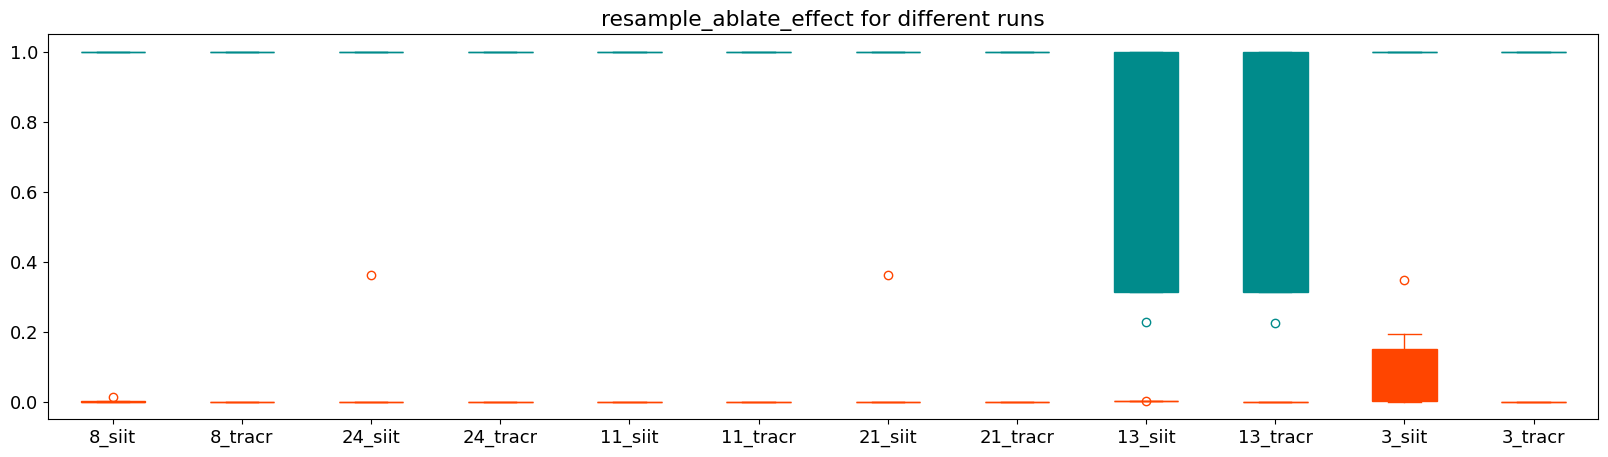

In [45]:
plot_results_in_box_plot(df_combined, df_combined_tracr, 
                        key = "resample_ablate_effect",
                        normalize_by_runs=False)

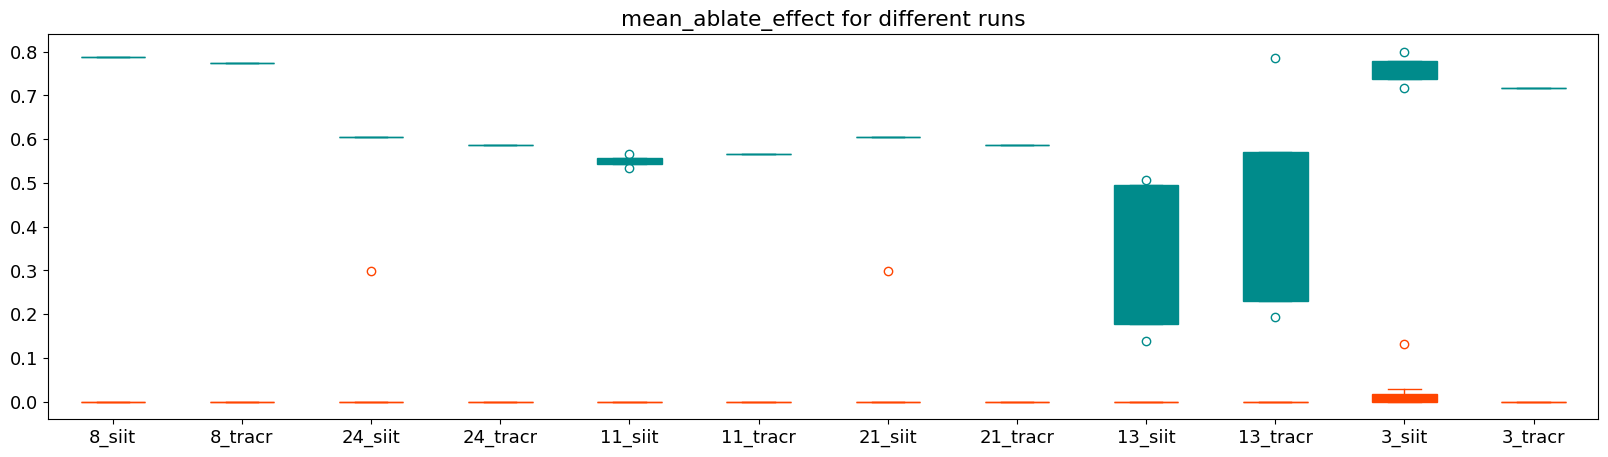

In [33]:
plot_results_in_box_plot(df_combined, df_combined_tracr, 
             key = "mean_ablate_effect",
             normalize_by_runs=False)

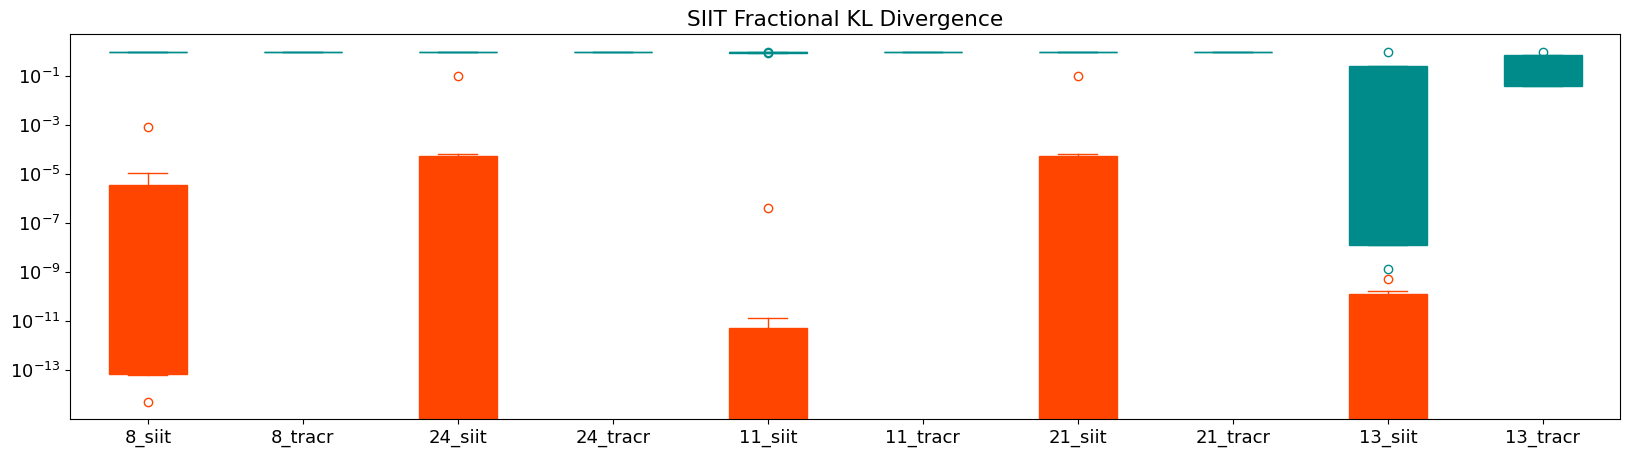

In [32]:
plot_results_in_box_plot(df_combined_kl, df_combined_kl_tracr, 
             key = "resample_ablate_effect",
             title="SIIT Fractional KL Divergence",
             normalize_by_runs=True,
             plot_y_log=True)

IIT

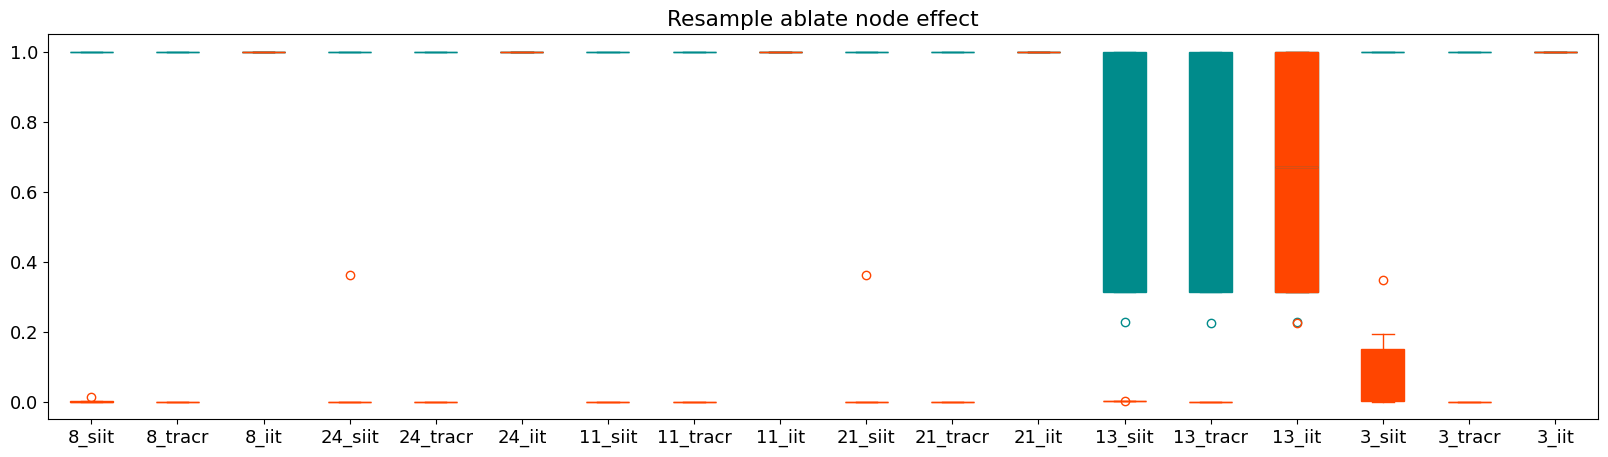

In [38]:
plot_results_in_box_plot(df_combined, df_combined_tracr, 
             df_iit=df_combined_iit,
             key = "resample_ablate_effect",
             title = "Resample ablate node effect",
             normalize_by_runs=False)

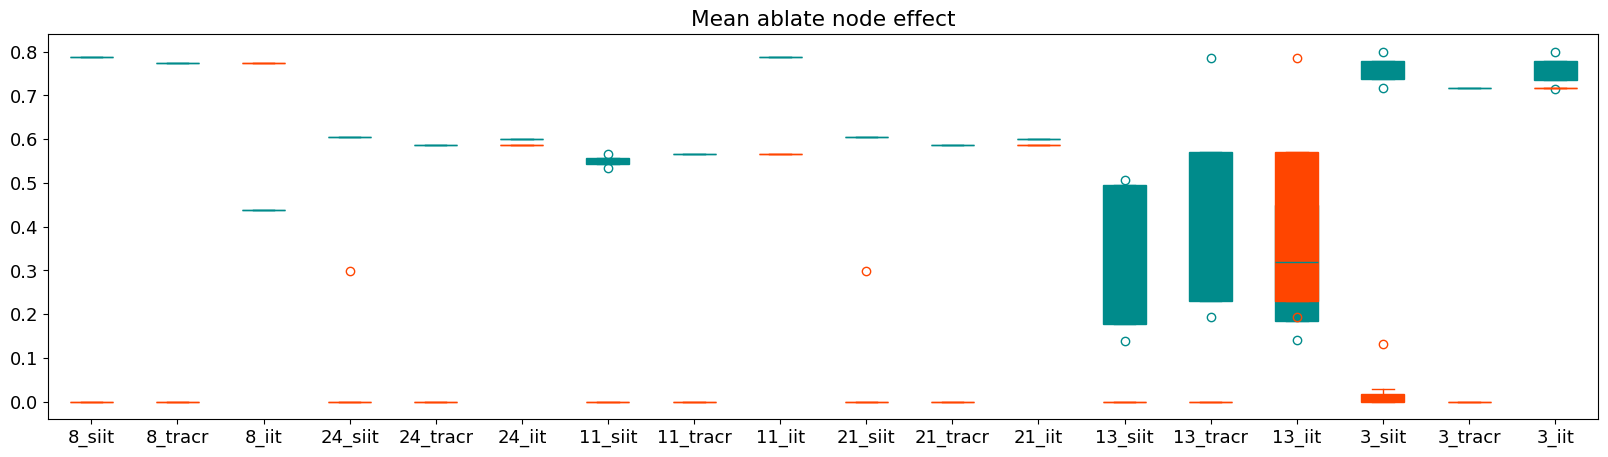

In [39]:
plot_results_in_box_plot(df_combined, df_combined_tracr,
             df_iit=df_combined_iit,
             key = "mean_ablate_effect",
             title = "Mean ablate node effect",
             normalize_by_runs=False)

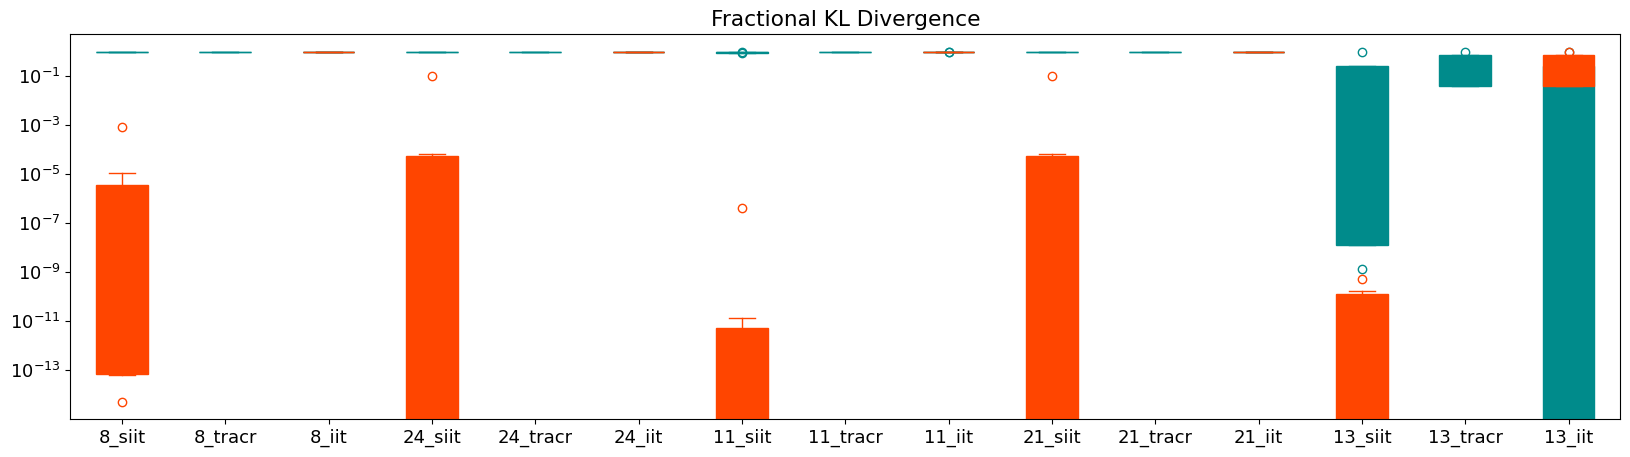

In [41]:
plot_results_in_box_plot(df_combined_kl, df_combined_kl_tracr,
             df_iit=df_combined_kl_iit,
             key = "resample_ablate_effect",
             title="Fractional KL Divergence",
             normalize_by_runs=True,
                plot_y_log=True)

In [ ]:
(
    in_circuit_list,
    not_in_circuit_list,
    tracr_in_circuit_list,
    tracr_not_in_circuit_list,
    _,
    _,
) = get_circuit_lists(df_combined, df_combined_tracr, 'resample_ablate_effect', False)

In [ ]:
def make_plot_lists(
        in_circuit_list,
        not_in_circuit_list,
        tracr_in_circuit_list,
        tracr_not_in_circuit_list,
        key,) -> tuple[tuple[list, list], tuple[list, list]]:
    def get_key(df, _key):
        try:
            return df[_key]
        except KeyError:
            return pd.Series()
    not_in_circuit_iit_effect = []
    not_in_circuit_tracr_effect = []
    for df in not_in_circuit_list:
        values = get_key(df, key).values
        not_in_circuit_iit_effect.extend(values)
        not_in_circuit_tracr_effect.extend([0] * len(values))

    in_circuit_iit_effect = []
    in_circuit_tracr_effect = []
    for df in tracr_in_circuit_list:
        values = list(get_key(df, key).values)
        nodes = list(df['node'].values)
        runs = list(df['run'].values)
        for i, node in enumerate(nodes):
            run = runs[i]
            case = find_run_in_cases(run, all_cases)
            if case is None:
                continue
            tracr_output = case.get_tracr_output()
            hl_ll_corr = TracrCorrespondence.from_output(case, tracr_output)
            iit_nodes = find_circuit_node_by_name(node, hl_ll_corr)
            if iit_nodes is None:
                raise ValueError(f"Node {node} not found in IIT circuit!")
            for iit_node in iit_nodes:
                node_str = create_name(iit_node)
                iit_node_row = df_combined[(df_combined['run'] == run) & (df_combined['node'] == node_str)]
                if iit_node_row.empty:
                    raise ValueError(f"Node {node_str} not found in IIT df")
                iit_node_row_index = iit_node_row.index[0]
                in_circuit_iit_effect.append(df_combined.loc[iit_node_row_index, key])
                in_circuit_tracr_effect.append(values[i])
    return (in_circuit_iit_effect, in_circuit_tracr_effect), (not_in_circuit_iit_effect, not_in_circuit_tracr_effect)

In [ ]:
def plot_results_in_scatter_plot(
    results,
    results_tracr,
    key="resample_ablate_effect",
    normalize_by_runs=True,
    figsize=(10, 5),
    plot_minmax_lines=True,
    mean=False,
    title=None,
):
    (
        in_circuit_list,
        not_in_circuit_list,
        tracr_in_circuit_list,
        tracr_not_in_circuit_list,
        _,
        _,
    ) = get_circuit_lists(results, results_tracr, key, normalize_by_runs)
    def get_key(df):
        try:
            return df[key]
        except KeyError:
            return pd.Series()
    if mean:
        iit_in_circuit_effect_list = [get_key(df).mean() for df in in_circuit_list]
        iit_not_in_circuit_effect_list = [get_key(df).mean() for df in not_in_circuit_list]
        tracr_in_circuit_effect_list = [get_key(df).mean() for df in tracr_in_circuit_list]
        tracr_not_in_circuit_effect_list = [get_key(df).mean() for df in tracr_not_in_circuit_list]
    else:
        (iit_in_circuit_effect_list, tracr_in_circuit_effect_list), (iit_not_in_circuit_effect_list, tracr_not_in_circuit_effect_list) = make_plot_lists(
            in_circuit_list,
            not_in_circuit_list,
            tracr_in_circuit_list,
            tracr_not_in_circuit_list,
            key
        )
    plt.figure(figsize=figsize)
    if title is not None:
        plt.title(title)
    else:
        plt.title(f"Comparing {key} for different runs")
    import numpy as np
    print(
        tracr_in_circuit_effect_list, 
        iit_in_circuit_effect_list,
        tracr_not_in_circuit_effect_list,
        iit_not_in_circuit_effect_list
    )
    plt.scatter(
        np.abs(tracr_in_circuit_effect_list),
        np.abs(iit_in_circuit_effect_list),
        color="darkcyan",
        label="iit_in_circuit",
        alpha=0.5,
        s=150,
    )
    print(len(tracr_not_in_circuit_effect_list), len(iit_not_in_circuit_effect_list))
    plt.scatter(
        np.abs(tracr_not_in_circuit_effect_list),
        np.abs(iit_not_in_circuit_effect_list),
        color="orangered",
        label="iit_not_in_circuit",
        alpha=0.2,
        s=150,
    )
    plt.plot([0, 1], [0, 1], color="black", linestyle="--", alpha=0.9)
    plt.xlabel("tracr ablate effect")
    plt.ylabel("iit ablate effect")
    legend_list = [
        "in_circuit",
        "not_in_circuit",
        "x=y line"
    ]
    if plot_minmax_lines:
        plt.hlines(
            [min(iit_in_circuit_effect_list)],
            0, 1,
            color="darkcyan",
            linestyle="--",
        )
        plt.hlines(
            [max(iit_not_in_circuit_effect_list)],
            0, 1,
            color="maroon",
            linestyle="--",
        )
        # plot the gap
        gap_color = "green" if min(iit_in_circuit_effect_list) > max(iit_not_in_circuit_effect_list) else "red"
        plt.plot(
            [0.5, 0.5],
            [min(iit_in_circuit_effect_list), max(iit_not_in_circuit_effect_list)],
            color=gap_color,
            linestyle="--",
        )
        # fill the gap with color
        plt.fill_between(
            [0, 1],
            min(iit_in_circuit_effect_list),
            max(iit_not_in_circuit_effect_list),
            color=gap_color,
            alpha=0.2,
        )

        legend_list += ["min_in_circuit", "max_not_in_circuit", "gap"]

    plt.legend(legend_list) #, loc='center left', bbox_to_anchor=(1, 0.7))


[1.0, 1.0, 1.0, 0.6416721029783914, 1.0, 0.8516066534586193, 0.9999999999999996] [1.0, 1.0, 1.0, 0.6411932363790154, 1.0, 0.8516066534586193, 0.9999999999999996] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0.0, 0.040091275763517356, 0.040091275763517356, 0.0016189334366709669, 0.0014946442620427222, 0.0, 0.10620629496079521]
7 7


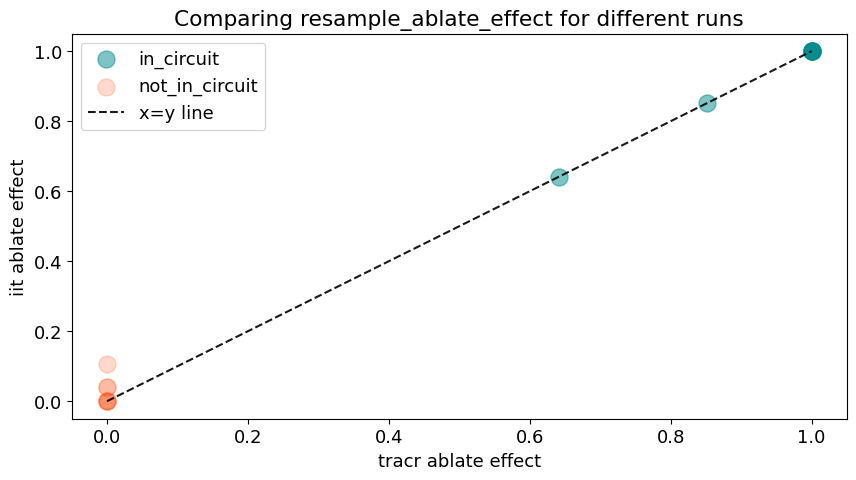

In [ ]:
plot_results_in_scatter_plot(df_combined, df_combined_tracr,
                key = "resample_ablate_effect",
                normalize_by_runs=False,
                plot_minmax_lines=False,
                mean=True)

[1.0, 1.0, 1.0, 1.0, 1.0, 0.3412660180679928, 0.2254223938455726, 1.0, 1.0, 0.7101729559026297, 0.7258678248482078, 0.9851929165418198, 0.9851929165418198, 0.9999999999999996, 0.9999999999999996] [1.0, 1.0, 1.0, 1.0, 0.9988696693473456, 0.3396592738714397, 0.227374332949931, 0.9988696693473456, 1.0, 0.7101729559026297, 0.7258678248482078, 0.9851929165418198, 0.9851929165418198, 0.9999999999999996, 0.9999999999999996] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3608214818716562, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3608214818716562, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0016188418601002, 0.0016188418601002, 0.0016190269294115, 0.0016188418601002, 0.0016188418601002, 0.0016192062502135, 0.0, 1.6526879073005065e-06, 0.000135657165834, 0.0, 0.0, 0.0002556910299634, 0.0, 0.0130587974746798, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

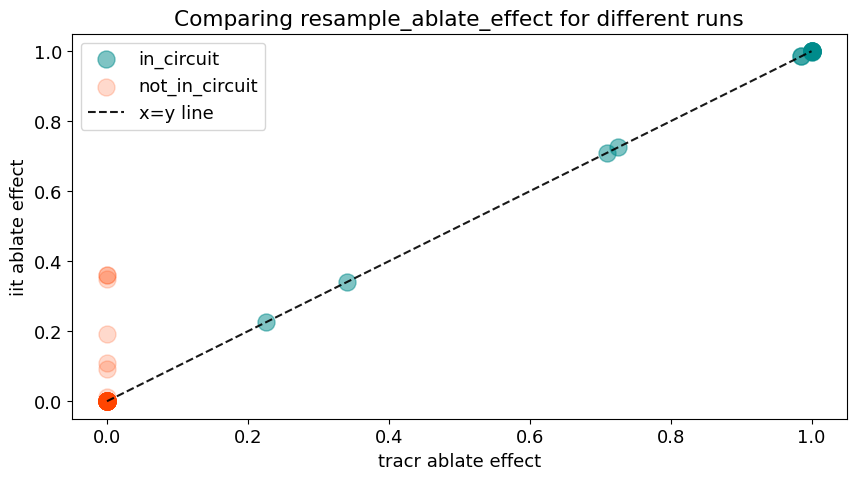

In [ ]:
plot_results_in_scatter_plot(df_combined, df_combined_tracr,
                key = "resample_ablate_effect",
                normalize_by_runs=False,
                plot_minmax_lines=False,
                mean=False)

[0.564688846756477, 0.5858061689464517, 0.5858061689464517, 0.4299501614656697, 0.7746834587412101, 0.67726882381257, 0.715624999440918]

 [0.5494965649737686, 0.6048019932920792, 0.6048019932920792, 0.3315505851735081, 0.7875942884775373, 0.6783666147603964, 0.7578124994079589] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0.0, 0.033053460235792934, 0.033053460235792934, 0.0, 0.0, 0.0, 0.024776785694928815]
7 7


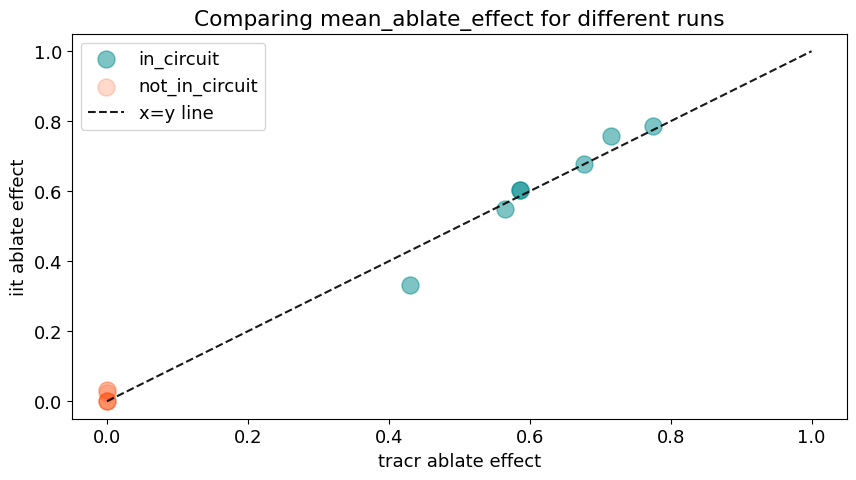

In [ ]:
plot_results_in_scatter_plot(df_combined, df_combined_tracr,
                key = "mean_ablate_effect",
                normalize_by_runs=False,
                plot_minmax_lines=False,
                mean=True)

[0.564688846756477, 0.564688846756477, 0.5858061689464517, 0.5858061689464517, 0.7860654630471697, 0.2413321658515539, 0.1927801723365071, 0.4996228446274482, 0.7746834587412101, 0.7890961742527126, 0.7175680223418168, 0.6012055493278753, 0.6012055493278753, 0.715624999440918, 0.715624999440918] [0.564688846756477, 0.5343042831910604, 0.6048019932920792, 0.6048019932920792, 0.4915761480789915, 0.1886863186922682, 0.1394250593198373, 0.5065148146029353, 0.7875942884775373, 0.7765389274904854, 0.7345164328953495, 0.6012055493278753, 0.6012055493278753, 0.7999999993749999, 0.715624999440918] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2974811421221364, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2974811421221364, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

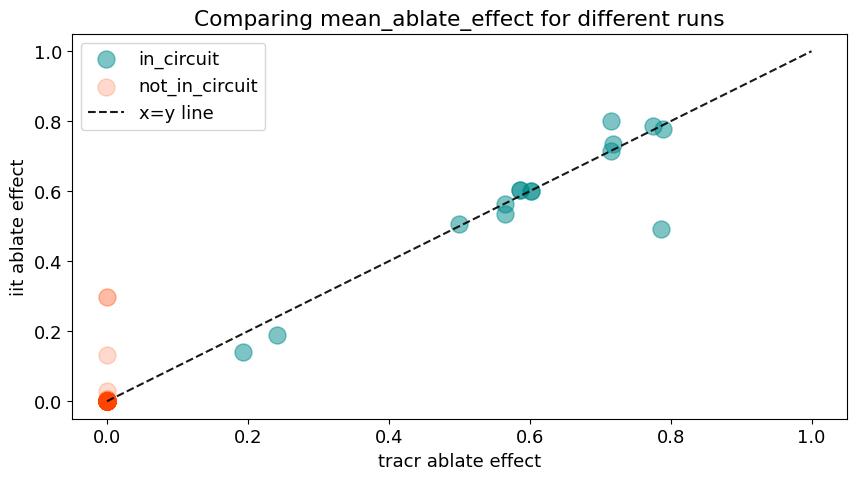

In [ ]:
plot_results_in_scatter_plot(df_combined, df_combined_tracr,
                key = "mean_ablate_effect",
                normalize_by_runs=False,
                plot_minmax_lines=False,
                mean=False)

[1.0, 1.0, 1.0, 1.0, 1.0, 0.3412660180679928, 0.2254223938455726, 1.0, 1.0, 0.9999999999999996, 0.9999999999999996] [1.0, 1.0, 1.0, 1.0, 0.9988696693473456, 0.3396592738714397, 0.227374332949931, 0.9988696693473456, 1.0, 0.9999999999999996, 0.9999999999999996] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [0.0, 0.0192992675329243, 0.0, 0.0005447070412952, 0.0, 0.0, 0.0, 0.9999999999999368, 0.0, 0.0, 0.0, 0.9996299231814242, 0.0, 0.021439971342285, 0.0, 0.0, 0.9999999999999368, 0.0, 0.0, 0.0, 0.9996299231814242, 0.0, 0.021439971342285, 0.0, 0.0, 0.9999999999999368, 0.0016188418601002, 0.0016188418601002, 0.0016188418601002, 0.0016188418601002, 0.0016188418601002, 0.001836065327556, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9999999999999368, 0.0, 0.1113550550081237, 0.0002813327236834, 0.0, 0.2441592638129254, 0.0, 0.1693587456828427, 0.9999999999999998]
48 48


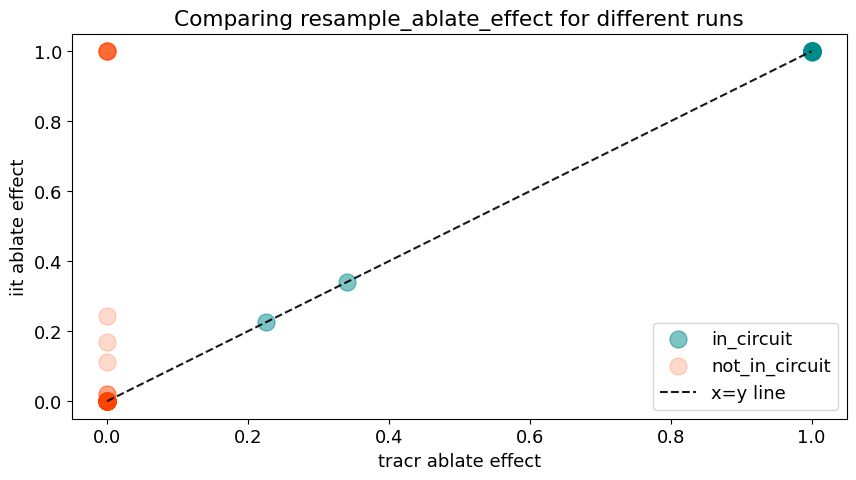

In [ ]:
plot_results_in_scatter_plot(df_combined_iit, df_combined_tracr_iit,
                key = "resample_ablate_effect",
                normalize_by_runs=False,
                plot_minmax_lines=False,
                mean=False)

[0.564688846756477, 0.564688846756477, 0.5858061689464517, 0.5858061689464517, 0.7860654630471697, 0.2413321658515539, 0.1927801723365071, 0.4996228446274482, 0.7746834587412101, 0.715624999440918, 0.715624999440918] [0.564688846756477, 0.5343042831910604, 0.6048019932920792, 0.6048019932920792, 0.4915761480789915, 0.1886863186922682, 0.1394250593198373, 0.5065148146029353, 0.7875942884775373, 0.7999999993749999, 0.715624999440918] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [0.0, 0.0067631074142357, 0.0, 3.19693094504276e-05, 0.0, 0.0, 0.0, 0.3374318652771886, 0.0, 0.0, 0.0, 0.5107075714751885, 0.0, 0.0023159732886237, 0.0, 0.0, 0.5886007719941447, 0.0, 0.0, 0.0, 0.5107075714751885, 0.0, 0.0023159732886237, 0.0, 0.0, 0.5886007719941447, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2273855098215312, 0.0, 0.0164062499871826, 0.0, 0.0, 0.0830078124351501, 0.0, 0.0, 0

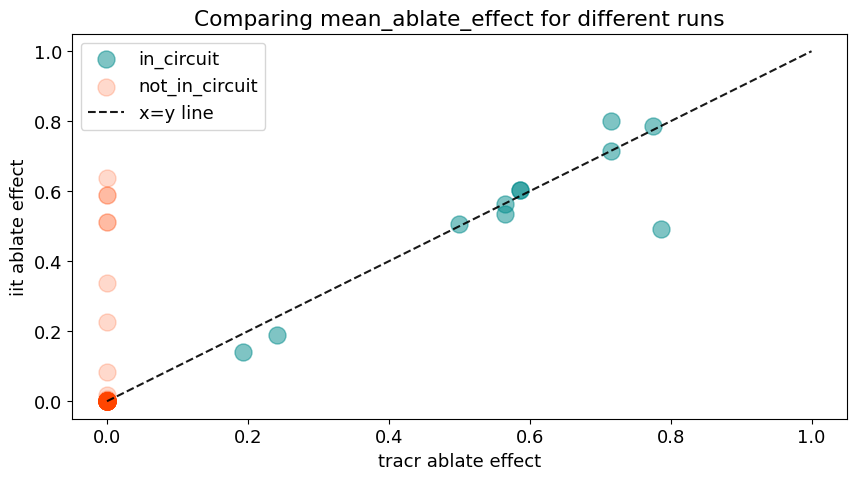

In [ ]:
plot_results_in_scatter_plot(df_combined_iit, df_combined_tracr_iit,
                key = "mean_ablate_effect",
                normalize_by_runs=False,
                plot_minmax_lines=False,
                mean=False)

[1.0, 1.0, 1.0, 1.0, 1.0, 0.03812599850187552, 0.03812599850187552, 0.6730572688026196, 1.0] [1.0, 1.0, 1.0, 1.0, 0.227374332949931, 0.9988696693473456, 0.9988696693473456, 0.3396592738714397, 1.0] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [8.143929706868303e-14, 0.0, 0.0, 0.0, 1.3533156142312512e-11, 2.3517777146023617e-12, 3.2123925585762945e-13, 3.9868748944949463e-07, 5.497553355723648e-07, 2.1994710133983592e-06, 4.937992464971909e-06, 0.10491792706847157, -1.2756539514192559e-05, -3.796997711865473e-06, -1.8504554681272272e-05, 6.266470367215383e-05, 5.5558695653531333e-05, 5.497553355723648e-07, 2.1994710133983592e-06, 4.937992464971909e-06, 0.10491792706847157, -1.2756539514192559e-05, -3.796997711865473e-06, -1.8504554681272272e-05, 6.266470367215383e-05, 5.5558695653531333e-05, -2.1064475989878417e-13, -4.767013589468529e-14, 4.964287021817492e-10, -9.053380413818114e-13, -1.015171614671763e-12,

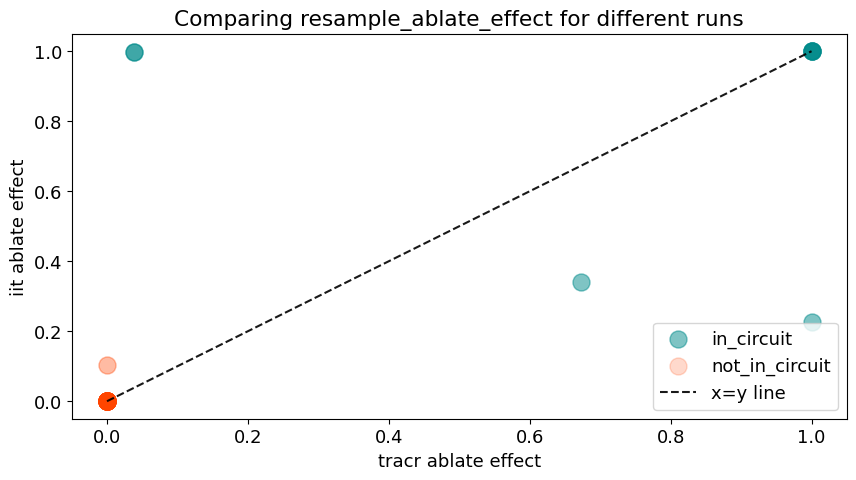

In [ ]:
plot_results_in_scatter_plot(df_combined_kl, df_combined_kl_tracr,
                key = "resample_ablate_effect",
                normalize_by_runs=True,
                plot_minmax_lines=False,
                mean=False)

[1.0, 1.0, 1.0, 1.0, 1.0, 0.03812599850187552, 0.03812599850187552, 0.6730572688026196, 1.0] [1.0, 1.0, 1.0, 1.0, 0.227374332949931, 0.9988696693473456, 0.9988696693473456, 0.3396592738714397, 1.0] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [1.3485795520043923e-07, 0.002946051873887455, 4.494069279547667e-08, 2.5938752243985267e-05, 2.086192243244634e-07, 2.6113663389595884e-08, -6.665372023869351e-09, 0.7513774730216092, 8.14839085740892e-09, -2.2660059064366224e-08, -2.1455812585410268e-08, 0.868525709438017, 1.1118882190877965e-06, 0.004898929241682517, 2.783657915490979e-06, 1.5382955986398666e-06, 0.835477890523226, 8.14839085740892e-09, -2.2660059064366224e-08, -2.1455812585410268e-08, 0.868525709438017, 1.1118882190877965e-06, 0.004898929241682517, 2.783657915490979e-06, 1.5382955986398666e-06, 0.835477890523226, 2.431341837042105e-07, 3.112709988879178e-08, 5.98444244448836e-08, 8.452580050469847e-

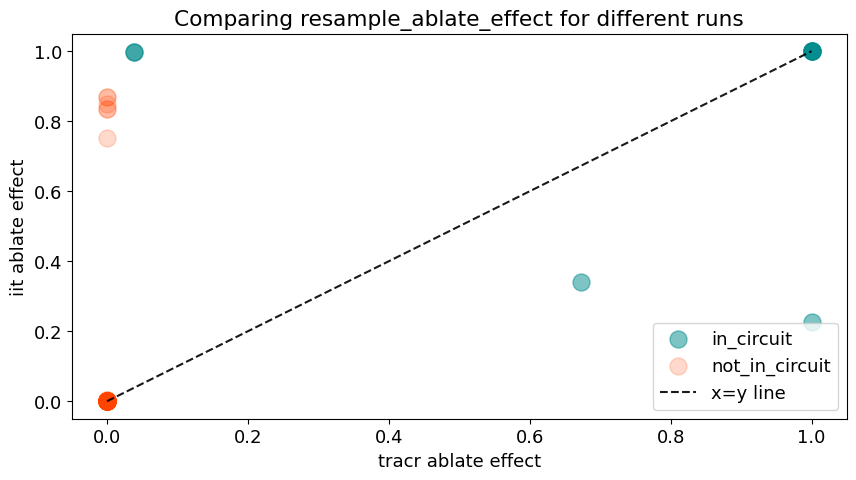

In [ ]:
plot_results_in_scatter_plot(df_combined_kl_iit, df_combined_kl_tracr_iit,
                key = "resample_ablate_effect",
                normalize_by_runs=True,
                plot_minmax_lines=False,
                mean=False)